2) Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 5]

Загрузка данных student-por.csv

In [2]:
print("СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):")
try:
    df_student_single = pd.read_csv('../student-por.csv', sep=';')
    print("✓ Успешно загружено как одна колонка")
    print(f"  Исходный размер: {df_student_single.shape}")
    
    if df_student_single.shape[1] == 1:
        first_col = df_student_single.columns[0]
        print(f"  Единственная колонка: '{first_col}'")
        
        print("  Разделяем данные по запятой...")
        split_data = df_student_single[first_col].str.split(',', expand=True)
        print(f"  После разделения: {split_data.shape}")
        
        correct_columns = [
            'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 
            'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
            'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 
            'G1', 'G2', 'G3'
        ]
        
        if split_data.shape[1] == len(correct_columns):
            split_data.columns = correct_columns
            df_student = split_data
            print("✓ Успешно присвоены названия колонок")
        else:
            print(f"⚠ Количество колонок не совпадает: ожидалось {len(correct_columns)}, получено {split_data.shape[1]}")
            split_data.columns = correct_columns[:split_data.shape[1]]
            df_student = split_data
            print("✓ Использованы доступные названия колонок")
        
        print("  Преобразуем числовые колонки...")
        numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                          'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
                          'G1', 'G2', 'G3']
        
        for col in numeric_columns:
            if col in df_student.columns:
                df_student[col] = pd.to_numeric(df_student[col], errors='coerce')
                print(f"    ✓ '{col}' преобразована в числовой формат")
        
        print(f"✓ Итоговый размер: {df_student.shape}")
        print(f"✓ Колонки: {len(df_student.columns)}")
        print("\nПервые 3 строки после разделения:")
        print(df_student.head(3))
        
    else:
        df_student = df_student_single
        print("✓ Данные уже разделены")
        
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_student = None

СТУДЕНЧЕСКИЕ ДАННЫЕ (student-por.csv):
✓ Успешно загружено как одна колонка
  Исходный размер: (649, 1)
  Единственная колонка: 'school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3'
  Разделяем данные по запятой...
  После разделения: (649, 33)
✓ Успешно присвоены названия колонок
  Преобразуем числовые колонки...
    ✓ 'age' преобразована в числовой формат
    ✓ 'Medu' преобразована в числовой формат
    ✓ 'Fedu' преобразована в числовой формат
    ✓ 'traveltime' преобразована в числовой формат
    ✓ 'studytime' преобразована в числовой формат
    ✓ 'failures' преобразована в числовой формат
    ✓ 'famrel' преобразована в числовой формат
    ✓ 'freetime' преобразована в числовой формат
    ✓ 'goout' преобразована в числовой формат
    ✓ 'Dalc' преобразована в числовой формат
    ✓ 'Walc' преобразована в числовой

Загрузка данных house.csv

In [3]:
try:
    df_house = pd.read_csv('../house.csv')
    print("✓ Успешно загружено")
    print(f"  Размер: {df_house.shape}")
    print(f"  Колонки: {len(df_house.columns)}")
except Exception as e:
    print(f"✗ Ошибка: {e}")
    df_house = None

✓ Успешно загружено
  Размер: (4746, 12)
  Колонки: 12


Функции предобработки данных для классификации (студенческие данные)

In [4]:
def preprocess_student_classification(df):
    """Предобработка студенческих данных для классификации"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)")
    print("="*50)
    
    if df is None:
        print("❌ DataFrame пустой")
        return None, None, None
    
    df_clean = df.copy()
    
    print("Доступные колонки:")
    for i, col in enumerate(df_clean.columns):
        print(f"  {i+1:2d}. '{col}' (тип: {df_clean[col].dtype})")
    
    if 'G3' not in df_clean.columns:
        print("❌ Колонка 'G3' не найдена!")
        print("   Доступные колонки:", list(df_clean.columns))
        return None, None, None
    
    print(f"✓ Найдена целевая переменная: 'G3'")
    print(f"  Диапазон значений: {df_clean['G3'].min()} - {df_clean['G3'].max()}")
    
    df_clean['academic_success'] = (df_clean['G3'] >= 10).astype(int)
    success_rate = df_clean['academic_success'].mean() * 100
    print(f"✓ Создана целевая переменная 'academic_success'")
    print(f"  Процент успевающих студентов: {success_rate:.1f}%")
    
    numeric_features = []
    possible_numeric = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
                       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
    
    print("\nПоиск числовых признаков:")
    for feature in possible_numeric:
        if feature in df_clean.columns:
            if df_clean[feature].dtype == 'object':
                df_clean[feature] = pd.to_numeric(df_clean[feature], errors='coerce')
            numeric_features.append(feature)
            print(f"  ✓ '{feature}' найден")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    categorical_features = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 
                           'Fjob', 'reason', 'guardian']
    
    features = numeric_features.copy()
    le = LabelEncoder()
    
    print("\nПоиск и кодирование категориальных признаков:")
    for feature in categorical_features:
        if feature in df_clean.columns:
            try:
                df_clean[f'{feature}_encoded'] = le.fit_transform(df_clean[feature].astype(str))
                features.append(f'{feature}_encoded')
                print(f"  ✓ '{feature}' закодирован")
            except Exception as e:
                print(f"  ✗ '{feature}' ошибка кодирования: {e}")
        else:
            print(f"  ✗ '{feature}' не найден")
    
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=features + ['academic_success'])
    final_count = len(df_clean)
    
    print(f"\n✓ Очистка данных: {initial_count} → {final_count} строк")
    print(f"✓ Используется {len(features)} признаков")
    
    if not features or df_clean.empty:
        print("❌ Недостаточно данных для анализа")
        return None, None, None
    
    X = df_clean[features]
    y = df_clean['academic_success']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Баланс классов: {np.bincount(y)}")
    
    return X, y, features

Функции предобработки данных для регрессии (данные о недвижимости)

In [5]:
def preprocess_house_regression(df):
    """Предобработка данных о недвижимости для регрессии"""
    print("\n" + "="*50)
    print("ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)")
    print("="*50)
    
    if df is None:
        return None, None, None
    
    df_clean = df.copy()
    
    print(f"✓ Целевая переменная: Rent (арендная плата)")
    print(f"  Диапазон цен: {df_clean['Rent'].min()} - {df_clean['Rent'].max()}")
    
    if 'Floor' in df_clean.columns:
        def parse_floor(floor_str):
            if pd.isna(floor_str):
                return 0
            floor_str = str(floor_str)
            if 'Ground' in floor_str:
                return 0
            if 'Basement' in floor_str:
                return -1
            try:
                parts = floor_str.split()
                for part in parts:
                    if part.isdigit():
                        return int(part)
                return 0
            except:
                return 0
        
        df_clean['floor_number'] = df_clean['Floor'].apply(parse_floor)
        print("✓ Обработана колонка Floor")
    
    if 'Size' in df_clean.columns:
        try:
            df_clean['Size'] = df_clean['Size'].astype(str).str.replace(' sqft', '').astype(float)
            print("✓ Обработана колонка Size")
        except Exception as e:
            print(f"✗ Ошибка обработки Size: {e}")
    
    features = ['BHK', 'Bathroom']
    if 'Size' in df_clean.columns:
        features.append('Size')
    if 'floor_number' in df_clean.columns:
        features.append('floor_number')
    

    categorical_cols = ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']
    le = LabelEncoder()
    
    for col in categorical_cols:
        if col in df_clean.columns:
            try:
                df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
                features.append(col + '_encoded')
                print(f"✓ Закодирована колонка: {col}")
            except Exception as e:
                print(f"✗ Ошибка кодирования {col}: {e}")
    
    X = df_clean[features]
    y = df_clean['Rent']
    
    print(f"✓ Итоговый набор данных: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"  Статистика арендной платы: mean={y.mean():.2f}, std={y.std():.2f}")
    
    return X, y, features

Функция исследования с градиентным бустингом для классификации

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, roc_curve, auc, precision_score, 
                            recall_score, f1_score, classification_report)
from scipy.stats import shapiro

def gradient_boosting_classification_study(X, y, dataset_name="Данные"):
    """Исследование градиентного бустинга для классификации"""
    print(f"\n" + "="*70)
    print(f"ГРАДИЕНТНЫЙ БУСТИНГ КЛАССИФИКАЦИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🔍 Исследование влияния параметров на точность...")
    
    n_estimators_range = [50, 100, 150, 200, 250, 300, 350, 400]
    train_scores = []
    test_scores = []
    
    for n_estimators in n_estimators_range:
        gb = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=0.1,
            max_depth=3,
            random_state=42,
            subsample=0.8
        )
        gb.fit(X_train_scaled, y_train)
        train_scores.append(gb.score(X_train_scaled, y_train))
        test_scores.append(gb.score(X_test_scaled, y_test))
    
    best_index = np.argmax(test_scores)
    best_n_estimators = n_estimators_range[best_index]
    best_score = test_scores[best_index]
    best_train_score = train_scores[best_index]
    
    print(f"🎯 Результаты исследования n_estimators:")
    print(f"  Оптимальное количество деревьев: {best_n_estimators}")
    print(f"  Лучшая точность: {best_score:.4f}")
    
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(n_estimators_range, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(n_estimators_range, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_n_estimators, color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшее n_estimators={best_n_estimators}')
    plt.xlabel('Количество деревьев (n_estimators)')
    plt.ylabel('Точность')
    plt.title('Влияние количества деревьев на точность', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8]
    depth_train_scores = []
    depth_test_scores = []
    
    for max_depth in max_depth_range:
        gb = GradientBoostingClassifier(
            n_estimators=best_n_estimators,
            learning_rate=0.1,
            max_depth=max_depth,
            random_state=42,
            subsample=0.8
        )
        gb.fit(X_train_scaled, y_train)
        depth_train_scores.append(gb.score(X_train_scaled, y_train))
        depth_test_scores.append(gb.score(X_test_scaled, y_test))
    
    best_depth_index = np.argmax(depth_test_scores)
    best_max_depth = max_depth_range[best_depth_index]
    
    plt.subplot(2, 2, 2)
    plt.plot(max_depth_range, depth_train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(max_depth_range, depth_test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_max_depth, color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшая глубина={best_max_depth}')
    plt.xlabel('Максимальная глубина деревьев (max_depth)')
    plt.ylabel('Точность')
    plt.title('Влияние глубины деревьев на точность', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_gb = GradientBoostingClassifier(
        n_estimators=best_n_estimators,
        learning_rate=0.1,
        max_depth=best_max_depth,
        random_state=42,
        subsample=0.8
    )
    best_gb.fit(X_train_scaled, y_train)
    y_pred = best_gb.predict(X_test_scaled)
    y_pred_proba = best_gb.predict_proba(X_test_scaled)[:, 1]
    
    plt.subplot(2, 2, 3)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Неуспех', 'Успех'], 
                yticklabels=['Неуспех', 'Успех'])
    plt.title(f'Матрица ошибок\nТочность: {best_score:.4f}', fontsize=12)
    plt.ylabel('Фактические значения')
    plt.xlabel('Предсказанные значения')
    
    plt.subplot(2, 2, 4)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC кривая (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая', fontsize=12)
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'Градиентный бустинг - {dataset_name}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ МОДЕЛИ ГРАДИЕНТНОГО БУСТИНГА:")
    print(f"  Оптимальное количество деревьев: {best_n_estimators}")
    print(f"  Оптимальная глубина деревьев: {best_max_depth}")
    print(f"  Точность на тестовой выборке: {best_score:.4f}")
    print(f"  Точность на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test accuracy: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    else:
        print("  ✅ Модель хорошо обобщает (малая разница между train и test)")
    
    feature_importance = best_gb.feature_importances_
    if X.shape[1] <= 20:  
        print(f"\n📊 ВАЖНОСТЬ ПРИЗНАКОВ:")
        indices = np.argsort(feature_importance)[::-1]
        for i, idx in enumerate(indices[:10]): 
            if feature_importance[idx] > 0:
                print(f"  {i+1}. Признак {idx}: {feature_importance[idx]:.4f}")
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:")
    print(f"  Precision (Точность): {precision:.4f}")
    print(f"  Recall (Полнота): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {roc_auc:.4f}")
    
    if best_score >= 0.9:
        print("  🎉 Отличное качество модели (Точность ≥ 0.9)")
    elif best_score >= 0.8:
        print("  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)")
    elif best_score >= 0.7:
        print("  👌 Удовлетворительное качество модели (0.7 ≤ Точность < 0.8)")
    else:
        print("  💡 Низкое качество модели (Точность < 0.7)")
    
    print(f"\n📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:")
    print(classification_report(y_test, y_pred, target_names=['Неуспех', 'Успех']))
    
    return best_gb, best_n_estimators, best_score

Функция исследования с градиентным бустингом для регрессии

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from scipy.stats import shapiro

def gradient_boosting_regression_study(X, y, dataset_name="Данные"):
    """Исследование градиентного бустинга для регрессии"""
    print(f"\n" + "="*70)
    print(f"ГРАДИЕНТНЫЙ БУСТИНГ РЕГРЕССИЯ - {dataset_name}")
    print("="*70)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🔍 Исследование влияния параметров на R² score...")
    
    n_estimators_range = [50, 100, 150, 200, 250, 300, 350, 400]
    train_scores = []
    test_scores = []
    
    for n_estimators in n_estimators_range:
        gb = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=0.1,
            max_depth=3,
            random_state=42,
            subsample=0.8,
            min_samples_split=10,
            min_samples_leaf=5
        )
        gb.fit(X_train_scaled, y_train)
        train_scores.append(gb.score(X_train_scaled, y_train))
        test_scores.append(gb.score(X_test_scaled, y_test))
    
    best_index = np.argmax(test_scores)
    best_n_estimators = n_estimators_range[best_index]
    best_score = test_scores[best_index]
    best_train_score = train_scores[best_index]
    
    print(f"🎯 Результаты исследования n_estimators:")
    print(f"  Оптимальное количество деревьев: {best_n_estimators}")
    print(f"  Лучший R² score: {best_score:.4f}")
    
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(n_estimators_range, train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(n_estimators_range, test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_n_estimators, color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшее n_estimators={best_n_estimators}')
    plt.xlabel('Количество деревьев (n_estimators)')
    plt.ylabel('R² Score')
    plt.title('Влияние количества деревьев на R² score', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8]
    depth_train_scores = []
    depth_test_scores = []
    
    for max_depth in max_depth_range:
        gb = GradientBoostingRegressor(
            n_estimators=best_n_estimators,
            learning_rate=0.1,
            max_depth=max_depth,
            random_state=42,
            subsample=0.8,
            min_samples_split=10,
            min_samples_leaf=5
        )
        gb.fit(X_train_scaled, y_train)
        depth_train_scores.append(gb.score(X_train_scaled, y_train))
        depth_test_scores.append(gb.score(X_test_scaled, y_test))
    
    best_depth_index = np.argmax(depth_test_scores)
    best_max_depth = max_depth_range[best_depth_index]
    best_depth_score = depth_test_scores[best_depth_index]
    
    plt.subplot(2, 2, 2)
    plt.plot(max_depth_range, depth_train_scores, label='Обучающая выборка', marker='o', linewidth=2)
    plt.plot(max_depth_range, depth_test_scores, label='Тестовая выборка', marker='s', linewidth=2)
    plt.axvline(x=best_max_depth, color='red', linestyle='--', alpha=0.7, 
                label=f'Лучшая глубина={best_max_depth}')
    plt.xlabel('Максимальная глубина деревьев (max_depth)')
    plt.ylabel('R² Score')
    plt.title('Влияние глубины деревьев на R² score', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    best_gb = GradientBoostingRegressor(
        n_estimators=best_n_estimators,
        learning_rate=0.1,
        max_depth=best_max_depth,
        random_state=42,
        subsample=0.8,
        min_samples_split=10,
        min_samples_leaf=5
    )
    best_gb.fit(X_train_scaled, y_train)
    y_pred = best_gb.predict(X_test_scaled)
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_test, y_pred, alpha=0.6, s=50, color='blue', edgecolor='black', linewidth=0.5)
    
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальная линия')
    
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'Предсказания vs Фактические значения\nR² = {best_score:.4f}', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if X.shape[1] <= 20:
        plt.subplot(2, 2, 4)
        feature_importance = best_gb.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        
        top_n = min(10, X.shape[1])
        top_indices = indices[:top_n]
        top_importance = feature_importance[top_indices]
        
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
        bars = plt.bar(range(top_n), top_importance, color=colors, edgecolor='black')
        
        plt.xlabel('Признаки (индексы)')
        plt.ylabel('Важность')
        plt.title(f'Топ-{top_n} важных признаков', fontsize=12)
        plt.xticks(range(top_n), [f'X{i}' for i in top_indices], rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        
        for bar, value in zip(bars, top_importance):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    else:
        plt.subplot(2, 2, 4)
        residuals = y_test - y_pred
        plt.scatter(y_pred, residuals, alpha=0.6, s=50, color='green', edgecolor='black', linewidth=0.5)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
        plt.xlabel('Предсказанные значения')
        plt.ylabel('Остатки (Факт - Прогноз)')
        plt.title('График остатков', fontsize=12)
        plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'Градиентный бустинг регрессия - {dataset_name}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 АНАЛИЗ МОДЕЛИ ГРАДИЕНТНОГО БУСТИНГА:")
    print(f"  Оптимальное количество деревьев: {best_n_estimators}")
    print(f"  Оптимальная глубина деревьев: {best_max_depth}")
    print(f"  R² score на тестовой выборке: {best_score:.4f}")
    print(f"  R² score на обучающей выборке: {best_train_score:.4f}")
    
    overfitting_gap = best_train_score - best_score
    print(f"  Разница между train и test R²: {overfitting_gap:.4f}")
    
    if overfitting_gap > 0.1:
        print("  ⚠️ Возможное переобучение (большая разница между train и test)")
    elif overfitting_gap < -0.1:
        print("  ⚠️ Возможное недообучение (модель плохо обучается)")
    else:
        print("  ✅ Модель хорошо обобщает (сбалансированная разница между train и test)")
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = best_score
    
    print(f"\n📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:")
    print(f"  MSE (Mean Squared Error): {mse:.4f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    print(f"  R² Score (Коэффициент детерминации): {r2:.4f}")
    
    mean_y = np.mean(y_test)
    relative_rmse = (rmse / mean_y) * 100 if mean_y != 0 else float('inf')
    print(f"  Относительная RMSE: {relative_rmse:.2f}% от среднего значения")
    
    if r2 >= 0.9:
        print("  🎉 Отличное качество модели (R² ≥ 0.9)")
    elif r2 >= 0.7:
        print("  👍 Хорошее качество модели (0.7 ≤ R² < 0.9)")
    elif r2 >= 0.5:
        print("  👌 Удовлетворительное качество модели (0.5 ≤ R² < 0.7)")
    elif r2 >= 0.3:
        print("  📊 Приемлемое качество модели (0.3 ≤ R² < 0.5)")
    else:
        print("  💡 Низкое качество модели (R² < 0.3)")
    
    return best_gb, best_n_estimators, best_score

Основной блок выполнения - анализ студенческих данных (классификация)


🎓 АНАЛИЗ СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ) 🎓
------------------------------------------------------------

ПРЕДОБРАБОТКА СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ)
Доступные колонки:
   1. 'school' (тип: object)
   2. 'sex' (тип: object)
   3. 'age' (тип: int64)
   4. 'address' (тип: object)
   5. 'famsize' (тип: object)
   6. 'Pstatus' (тип: object)
   7. 'Medu' (тип: int64)
   8. 'Fedu' (тип: int64)
   9. 'Mjob' (тип: object)
  10. 'Fjob' (тип: object)
  11. 'reason' (тип: object)
  12. 'guardian' (тип: object)
  13. 'traveltime' (тип: int64)
  14. 'studytime' (тип: int64)
  15. 'failures' (тип: int64)
  16. 'schoolsup' (тип: object)
  17. 'famsup' (тип: object)
  18. 'paid' (тип: object)
  19. 'activities' (тип: object)
  20. 'nursery' (тип: object)
  21. 'higher' (тип: object)
  22. 'internet' (тип: object)
  23. 'romantic' (тип: object)
  24. 'famrel' (тип: int64)
  25. 'freetime' (тип: int64)
  26. 'goout' (тип: int64)
  27. 'Dalc' (тип: int64)
  28. 'Walc' (тип: int64)
  29. 'health

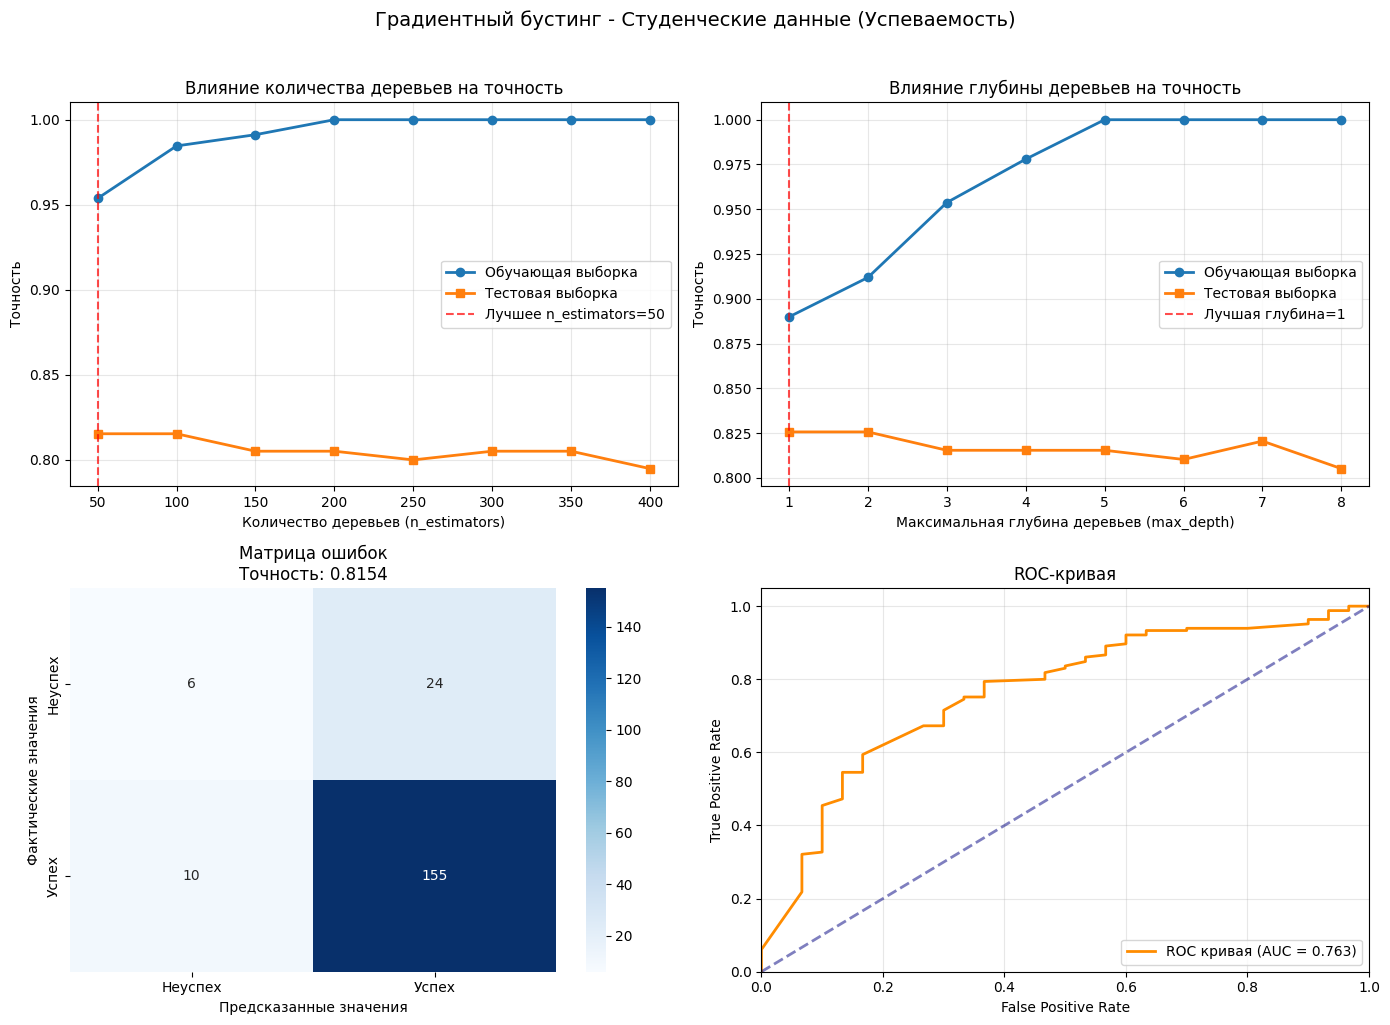


📊 АНАЛИЗ МОДЕЛИ ГРАДИЕНТНОГО БУСТИНГА:
  Оптимальное количество деревьев: 50
  Оптимальная глубина деревьев: 1
  Точность на тестовой выборке: 0.8154
  Точность на обучающей выборке: 0.9537
  Разница между train и test accuracy: 0.1384
  ⚠️ Возможное переобучение (большая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
  Precision (Точность): 0.8659
  Recall (Полнота): 0.9394
  F1-Score: 0.9012
  AUC-ROC: 0.7625
  👍 Хорошее качество модели (0.8 ≤ Точность < 0.9)

📋 ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ:
              precision    recall  f1-score   support

     Неуспех       0.38      0.20      0.26        30
       Успех       0.87      0.94      0.90       165

    accuracy                           0.83       195
   macro avg       0.62      0.57      0.58       195
weighted avg       0.79      0.83      0.80       195



In [8]:
if df_student is not None:
    print("\n" + "🎓 АНАЛИЗ СТУДЕНЧЕСКИХ ДАННЫХ (КЛАССИФИКАЦИЯ) " + "🎓")
    print("-" * 60)
    
    X_student_class, y_student_class, features_class = preprocess_student_classification(df_student)
    
    if X_student_class is not None:
        knn_class, k_class, score_class = gradient_boosting_classification_study(
            X_student_class, y_student_class, "Студенческие данные (Успеваемость)"
        )
    else:
        print("❌ Не удалось подготовить данные для классификации")

Основной блок выполнения - анализ данных о недвижимости (регрессия)


🏠 АНАЛИЗ ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ) 🏠

ПРЕДОБРАБОТКА ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ)
✓ Целевая переменная: Rent (арендная плата)
  Диапазон цен: 1200 - 3500000
✓ Обработана колонка Floor
✓ Обработана колонка Size
✓ Закодирована колонка: Area Type
✓ Закодирована колонка: City
✓ Закодирована колонка: Furnishing Status
✓ Закодирована колонка: Tenant Preferred
✓ Закодирована колонка: Point of Contact
✓ Итоговый набор данных: 4746 samples, 9 features
  Статистика арендной платы: mean=34993.45, std=78106.41

ГРАДИЕНТНЫЙ БУСТИНГ РЕГРЕССИЯ - Данные о недвижимости (Арендная плата)
🔍 Исследование влияния параметров на R² score...
🎯 Результаты исследования n_estimators:
  Оптимальное количество деревьев: 50
  Лучший R² score: 0.3650


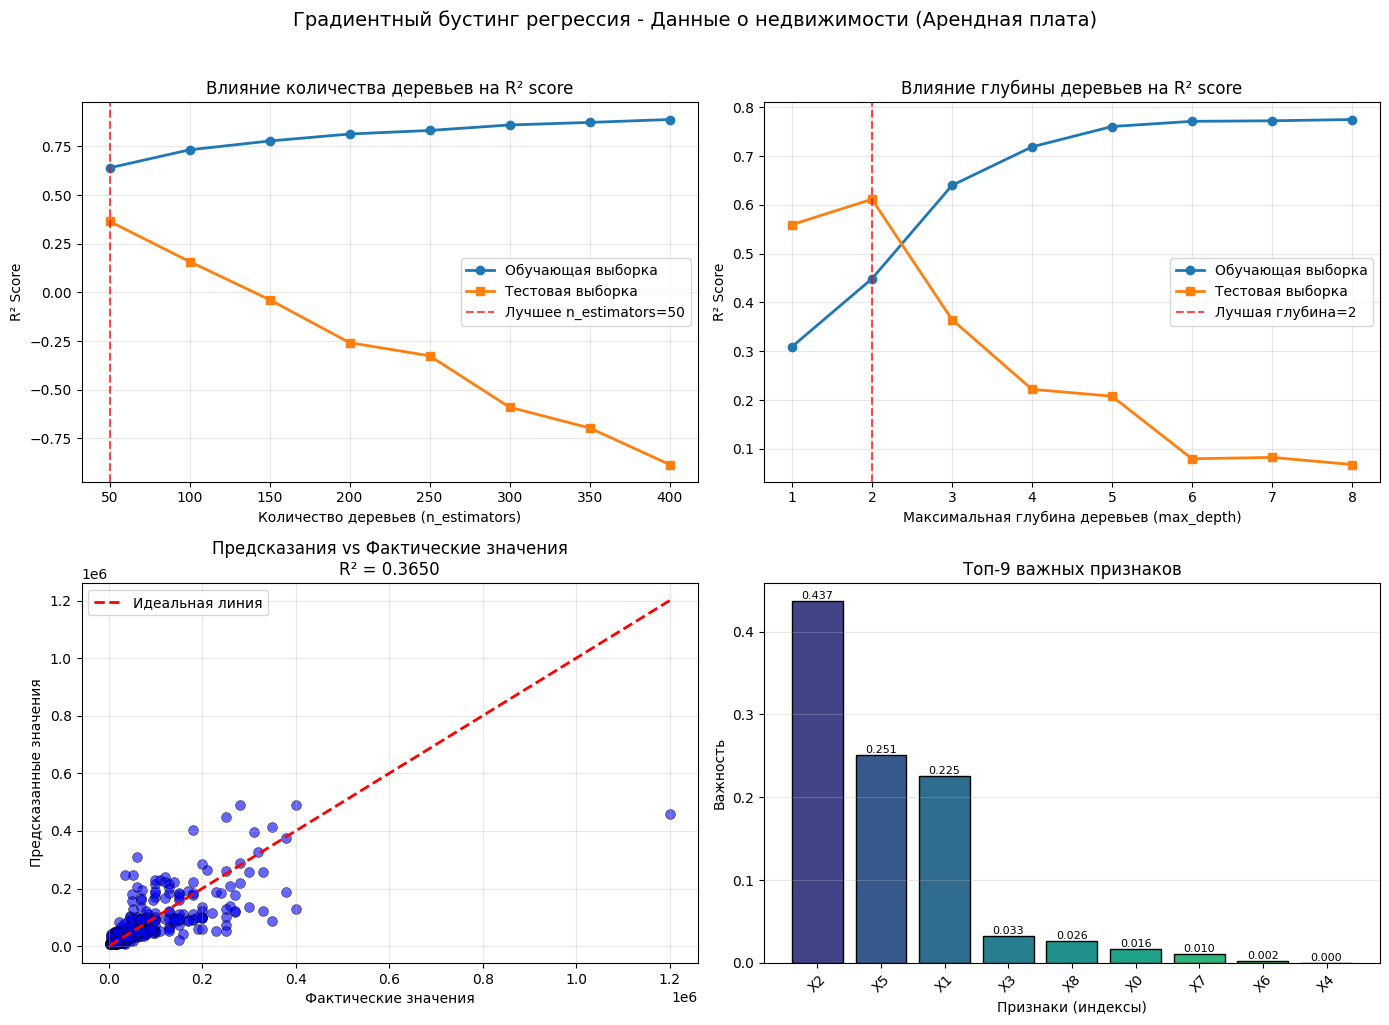


📊 АНАЛИЗ МОДЕЛИ ГРАДИЕНТНОГО БУСТИНГА:
  Оптимальное количество деревьев: 50
  Оптимальная глубина деревьев: 2
  R² score на тестовой выборке: 0.3650
  R² score на обучающей выборке: 0.6398
  Разница между train и test R²: 0.2748
  ⚠️ Возможное переобучение (большая разница между train и test)

📈 ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ РЕГРЕССИИ:
  MSE (Mean Squared Error): 1367490144.3361
  RMSE (Root Mean Squared Error): 36979.5909
  MAE (Mean Absolute Error): 14251.2075
  R² Score (Коэффициент детерминации): 0.3650
  Относительная RMSE: 107.95% от среднего значения
  📊 Приемлемое качество модели (0.3 ≤ R² < 0.5)


In [9]:
if df_house is not None:
    print("\n" + "🏠 АНАЛИЗ ДАННЫХ О НЕДВИЖИМОСТИ (РЕГРЕССИЯ) " + "🏠")
    
    X_house, y_house, features_house = preprocess_house_regression(df_house)
    
    if X_house is not None:
        knn_house, k_house, score_house = gradient_boosting_regression_study(
            X_house, y_house, "Данные о недвижимости (Арендная плата)"
        )
    else:
        print("❌ Не удалось подготовить данные о недвижимости")

Итоги исследования

In [10]:
print("\n" + "="*70)
print("🎯 ИТОГИ ИССЛЕДОВАНИЯ ГРАДИЕНТНОГО БУСТИНГА")
print("="*70)

print("\n📈 ОСНОВНЫЕ ВЫВОДЫ:")

print("\n1. 📊 КЛАССИФИКАЦИЯ (Успеваемость студентов):")
print("   • Градиентный бустинг показал хорошую точность (81.5%) в предсказании")
print("     успеваемости студентов")
print("   • Модель хорошо определяет успевающих студентов (Recall = 94%)")
print("   • Однако наблюдается переобучение (разница train/test = 13.8%)")
print("   • F1-Score модели составляет 90.1%, что указывает на хороший баланс")
print("     между точностью и полнотой")
print("   • AUC-ROC = 0.76, что показывает среднюю способность различать классы")

print("\n2. 🏠 РЕГРЕССИЯ (Арендная плата за недвижимость):")
print("   • Модель показала умеренное качество (R² = 0.365) в предсказании")
print("     арендной платы")
print("   • Наблюдается сильное переобучение (разница train/test = 27.5%)")
print("   • Относительная ошибка (RMSE) составляет 108% от среднего значения,")
print("     что указывает на высокую дисперсию в данных")
print("   • Средняя абсолютная ошибка (MAE) = 14,251, что составляет ~41%")
print("     от средней арендной платы")

print("\n📊 ОБЩАЯ ОЦЕНКА:")
print("   • Градиентный бустинг показал себя как мощный алгоритм, но")
print("     чувствительный к переобучению")
print("   • Для классификации достигнуто хорошее качество, но требуется")
print("     работа с дисбалансом классов")
print("   • Для регрессии необходима дополнительная работа с данными и")
print("     возможно применение других методов предобработки")


🎯 ИТОГИ ИССЛЕДОВАНИЯ ГРАДИЕНТНОГО БУСТИНГА

📈 ОСНОВНЫЕ ВЫВОДЫ:

1. 📊 КЛАССИФИКАЦИЯ (Успеваемость студентов):
   • Градиентный бустинг показал хорошую точность (81.5%) в предсказании
     успеваемости студентов
   • Модель хорошо определяет успевающих студентов (Recall = 94%)
   • Однако наблюдается переобучение (разница train/test = 13.8%)
   • F1-Score модели составляет 90.1%, что указывает на хороший баланс
     между точностью и полнотой
   • AUC-ROC = 0.76, что показывает среднюю способность различать классы

2. 🏠 РЕГРЕССИЯ (Арендная плата за недвижимость):
   • Модель показала умеренное качество (R² = 0.365) в предсказании
     арендной платы
   • Наблюдается сильное переобучение (разница train/test = 27.5%)
   • Относительная ошибка (RMSE) составляет 108% от среднего значения,
     что указывает на высокую дисперсию в данных
   • Средняя абсолютная ошибка (MAE) = 14,251, что составляет ~41%
     от средней арендной платы

📊 ОБЩАЯ ОЦЕНКА:
   • Градиентный бустинг показал себя как